<a href="https://colab.research.google.com/github/awesome786engineer/Machine-Learning-Projects/blob/main/InstaFakeID_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from huggingface_hub import login
login()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
from datasets import load_dataset
dataset = load_dataset("nahiar/instagram_bot_detection")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Instagram_fake_profile_dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [6]:
df = dataset['train'].to_pandas()
df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


In [8]:
df.shape

(5000, 12)

In [14]:
# shuffle the DF before applying train test split
df_shuffled = df.sample(frac = 1, random_state = 42).reset_index(drop = True)

splitting_point = int(0.8*len(df))
train_df = df_shuffled.iloc[:splitting_point]
test_df = df_shuffled.iloc[splitting_point:]

In [20]:
train_df = train_df.sample(frac = 1,random_state = 42).reset_index(drop = True)
test_df = test_df.sample(frac = 1,random_state = 42).reset_index(drop = True )

In [22]:
train_df.head()


,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,0,0.258771,1,0.0,0,0,0,0,0,6,56,1
1,1,0.000000,2,0.0,0,0,0,0,7,79,60,0
2,1,0.000000,1,0.0,0,87,0,1,27,759,372,0
3,0,0.149306,1,0.0,0,0,0,0,0,22,7,1
4,1,0.000000,1,0.0,0,0,0,1,127,275,244,0


In [23]:
test_df.head()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,0,0.219877,1,0.00,0,0,0,0,0,36,85,1
1,1,0.240000,1,0.24,1,0,0,1,4,18,106,1
2,0,0.285193,2,0.00,0,1,0,0,0,40,235,1
3,1,0.012695,3,0.00,0,2,0,0,57,6940,281,0
4,1,0.300000,1,0.00,0,5,0,1,1,51,420,1


In [24]:
len(train_df),len(test_df)

(4000, 1000)

Here "nums/length" and nums/length_full_name" is ratio of numerical characters in its user name and its full name

## MLWorkFLow ##

1. Data preprocessing used

    -  missing numerical values were replaced by mediian values reducing effect of  outliers
    -  missing categorical values(eg profile picture ) were replaced with mode  
2. Data transformation

    - apply one hot encoding for features "profile pic","private","external URL", presence = 1, absence = 0

3. Outlier Detection and Removal
    
    - use interquartile range or z- score method to detect and remove outlier that might skew the model performance

4. Feature selection

    - to avoid multicollinearity using "CORRELATION MATRIX"
    - lasso (L1) regularization to select importnat features by shrinking the less important features coefficients to zero
    - use RECURSIVE FEATURE ELEMINATION to select top performin features by iteratively training and eliminating weaker features

5. Normalization

    - normalize high performing features

6. Model building using
    - for now logistic regression only
    - later implement 1. KNN ,2. Random Forest,3. SVC(support vector classifier)




# OUTLIER DETECTION AND REMOVAL #

In [27]:
# plot the distribution of all numeric features
binary_columns = ["profile pic","name==username","external URL","private","fake"]
non_binary_columns = [col for col in train_df.columns if col not in binary_columns]

In [28]:
len(non_binary_columns)

7

In [29]:
non_binary_columns

['nums/length username',
 'fullname words',
 'nums/length fullname',
 'description length',
 '#posts',
 '#followers',
 '#follows']

In [ ]:
for col in non_binary_columns[1:]:
  sns.histplot(data = train_df,x = col,kde = True)
  plt.show

In [ ]:
# for i in range(5):
#   sns.histplot(data = train_df,x = non_binary_columns[i],kde = True)
#   plt.show()

In [33]:
# calculating skewness of all the attributes
train_df[non_binary_columns].skew()

,0
nums/length username,1.150374
fullname words,2.979278
nums/length fullname,4.088217
description length,1.857134
#posts,12.104331
#followers,15.363481
#follows,3.979301


In [34]:
train_df.corr()

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
profile pic,1.000000,-0.514861,0.254278,-0.221323,-0.076474,0.452044,0.187603,0.072260,0.206487,0.073029,0.236829,-0.786461
nums/length username,-0.514861,1.000000,-0.225131,0.453317,0.038497,-0.381569,-0.177070,-0.058910,-0.180174,-0.066262,-0.202779,0.660036
fullname words,0.254278,-0.225131,1.000000,-0.085531,-0.020701,0.316045,0.256554,-0.100964,0.053562,0.049261,0.085277,-0.297957
nums/length fullname,-0.221323,0.453317,-0.085531,1.000000,0.176347,-0.151229,-0.070977,-0.021757,-0.068054,-0.030700,-0.073823,0.298454
name==username,-0.076474,0.038497,-0.020701,0.176347,1.000000,-0.044610,-0.019890,0.036364,-0.022840,-0.007741,-0.017399,0.087060
description length,0.452044,-0.381569,0.316045,-0.151229,-0.044610,1.000000,0.392032,-0.065042,0.169141,0.030240,0.256313,-0.505106
external URL,0.187603,-0.177070,0.256554,-0.070977,-0.019890,0.392032,1.000000,-0.095852,0.133325,0.026522,0.128079,-0.228468
private,0.072260,-0.058910,-0.100964,-0.021757,0.036364,-0.065042,-0.095852,1.000000,-0.066085,-0.047882,-0.052539,-0.039287
#posts,0.206487,-0.180174,0.053562,-0.068054,-0.022840,0.169141,0.133325,-0.066085,1.000000,0.360601,0.117051,-0.248024
#followers,0.073029,-0.066262,0.049261,-0.030700,-0.007741,0.030240,0.026522,-0.047882,0.360601,1.000000,-0.007228,-0.088930


In [ ]:
selected_columns = ['profile pic','nums/length username','fullname words','description length','external URL']

# Applying IQR range for Outlier Detection #

In [ ]:
# making box plot for all the non_binary columns
# for col in non_binary_columns:
#   train_df.boxplot(column = col)
#   plt.show()

## capping the outliers #

In [ ]:
new_train_df = train_df.copy()
new_test_df = test_df.copy()

In [ ]:
def filter_iqr(original_df,col,new_df,train = True):
  Q1 = original_df[col].quantile(0.25)
  Q3 = original_df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR
  if train:
    new_df[col] = original_df[col].clip(lower = lower_limit ,upper = upper_limit)
  else:
    new_df[col] = test_df[col].clip(lower = lower_limit ,upper = upper_limit)
  return (lower_limit,upper_limit)


In [ ]:
from collections import defaultdict
quartile_limits = defaultdict(tuple)
for col in non_binary_columns:
  quartile_limits[col] = filter_iqr(train_df,col,new_train_df)
  filter_iqr(train_df,col,new_test_df,train = False)

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))

profile pic : ()
nums/length username : (np.float64(-0.46499999999999997), np.float64(0.7749999999999999))
fullname words : (np.float64(-0.5), np.float64(3.5))
description length : (np.float64(-51.0), np.float64(85.0))
external URL : ()


In [ ]:
new_train_df[non_binary_columns].skew()

,0
nums/length username,1.097140
fullname words,0.439757
nums/length fullname,0.000000
description length,1.289921
#posts,1.245706
#followers,1.270007
#follows,1.188118


In [ ]:
new_test_df[non_binary_columns].skew()

,0
nums/length username,1.058423
fullname words,0.719970
nums/length fullname,0.000000
description length,1.037544
#posts,1.657328
#followers,1.512365
#follows,0.958544


# Applying Logistic regression on IQR filtered data #

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train = new_train_df.drop('fake',axis = 1)
y_train = new_train_df['fake']
X_test = new_test_df.drop('fake',axis = 1)
y_test = new_test_df['fake']


# Logistic regression without sklearn #

In [ ]:
def sigmoid(z):
  return 1/(1 + np.exp(-z))

In [ ]:
def compute_cost_vectorized(X, w, b, y):
  m = X.shape[0]
  z = X @ w + b  # (m,n) @ (n,) -> (m,). Vectorized dot product for all examples!
  f_wb = sigmoid(z) # (m,) vector of all predictions

  # Element-wise operations on the entire vectors
  cost = -y * np.log(f_wb) - (1 - y) * np.log(1 - f_wb)
  total_cost = np.sum(cost) / m

  return total_cost


In [ ]:
def gradient_functions_vectorized(X, w, b, y):
  m, n = X.shape
  z = X @ w + b      # (m,) vector of z for all examples
  f_wb = sigmoid(z)  # (m,) vector of all predictions

  error = f_wb - y   # (m,) vector of all errors

  # (m,) * (m, n) is not what we want. We need (n,) result.
  # So we do (n, m) @ (m,) -> (n,)
  dj_dw = (X.T @ error) / m # transpose of X(m,n) is X.T(n,m)
  dj_db = np.sum(error) / m

  return dj_dw, dj_db

In [ ]:
def train_vectorized(X, y, alpha, num_iters):
  cost_history =[]
  w = np.zeros(X.shape[1])
  b = 0
  for i in range(num_iters):
    dj_dw, dj_db = gradient_functions_vectorized(X, w, b, y)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    if i % 1000 == 0: # Check cost less frequently to save time
        cost = compute_cost_vectorized(X, w, b, y)
        cost_history.append(cost)
        print(f"Iteration {i:5d}: Cost {cost:0.4f}")

  return w, b, cost_history


In [ ]:
def predict_vectorized(X, w, b):
  z = X @ w + b
  f_wb = sigmoid(z)
  p = f_wb >= 0.5 # Creates a boolean array
  return p.astype(int)

In [ ]:
#w, b,cost_history = train(X_train[selected_columns].values,y_train,0.01,15000)

In [ ]:
w, b,cost_history = train_vectorized(X_train[selected_columns].values,y_train,0.01,15000)

Iteration     0: Cost 0.6149
Iteration  1000: Cost 0.4768
Iteration  2000: Cost 0.4251
Iteration  3000: Cost 0.3922
Iteration  4000: Cost 0.3696
Iteration  5000: Cost 0.3532
Iteration  6000: Cost 0.3407
Iteration  7000: Cost 0.3309
Iteration  8000: Cost 0.3230
Iteration  9000: Cost 0.3164
Iteration 10000: Cost 0.3108
Iteration 11000: Cost 0.3060
Iteration 12000: Cost 0.3019
Iteration 13000: Cost 0.2982
Iteration 14000: Cost 0.2950


In [ ]:
y_pred = predict_vectorized(X_test[selected_columns].values,w,b)

In [ ]:
accuracy_score(y_test,y_pred)

0.9

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        60
           1       0.94      0.85      0.89        60

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



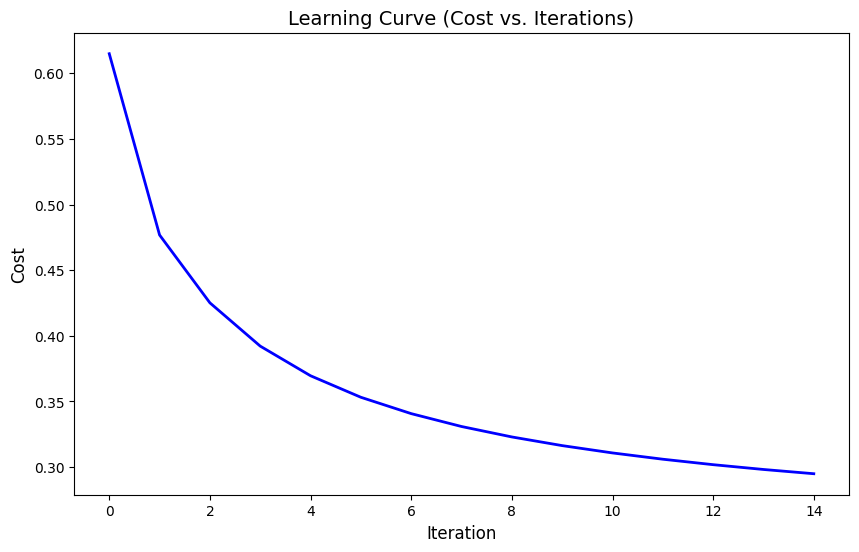

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(cost_history)),  # X-axis: iteration numbers (0 to 9999)
    cost_history,              # Y-axis: cost values
    color='blue',
    linestyle='solid',
    linewidth=2
)

plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cost', fontsize=12)
plt.title('Learning Curve (Cost vs. Iterations)', fontsize=14)
plt.show()


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        60
           1       0.94      0.85      0.89        60

    accuracy                           0.90       120
   macro avg       0.90      0.90      0.90       120
weighted avg       0.90      0.90      0.90       120



In [ ]:
w,b

(array([-2.80260132,  3.60909299, -0.35848741, -0.02805083, -1.33505898]),
 np.float64(2.659345278516535))

In [ ]:
# testing on real account
w = np.array([-2.80260132,  3.60909299, -0.35848741, -0.02805083, -1.33505898])
b = 2.659345278516536

In [ ]:
for col in selected_columns:
  print(col + " : " + str(quartile_limits[col]))